# Plot SSP Scenario Map

## 1. Import modules

In [1]:
import sys
import os
import platform
import importlib
import imageio
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import rc
rc('font', family='NanumGothic')

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/lsj'
    cpuserver_data_FP = '/Users/lsj/cpuserver_data'

elif  platform.system() == 'Linux':  # Linux

    base_FP = '/home/seongjun/lsj'
    cpuserver_data_FP = '/home/seongjun/cpuserver_data'
    
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
    
sys.path.append(base_FP + '/python_modules')

#hydroAI libs
import HydroAI.Data as Data
importlib.reload(Data);

# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore")

## 2. Set the path for loading data

In [2]:
SSP5_path = os.path.join(base_FP, 'SSP5')
nc_file = 'AR6_SSP585_5ENSMN_skorea_TA_gridraw_yearly_2021_2100.nc'
SSP5_FP = os.path.join(SSP5_path, nc_file)

## 3. Load variables from SSP(.nc file)

### 3.1 Check the variables name

In [3]:
# check the variable names and their units
Data.get_nc_variable_names_units(SSP5_FP)

+-----------+--------------------+-----------------------+
| Name      | Long Name          | Units                 |
+===========+====================+=======================+
| time      |                    | days since 2021-01-01 |
+-----------+--------------------+-----------------------+
| longitude | longitude          | degrees_east          |
+-----------+--------------------+-----------------------+
| latitude  | latitude           | degrees_north         |
+-----------+--------------------+-----------------------+
| TA        | TEMPERATURE OF AIR | degC                  |
+-----------+--------------------+-----------------------+


(['time', 'longitude', 'latitude', 'TA'],
 ['days since 2021-01-01', 'degrees_east', 'degrees_north', 'degC'],
 [None, 'longitude', 'latitude', 'TEMPERATURE OF AIR'])

### 3.2 Define the variables

In [4]:
ds = nc.Dataset(SSP5_FP, 'r')

avg_temp = ds.variables['TA'][:]
lat = ds.variables['latitude'][:]
lon = ds.variables['longitude'][:]
time = ds.variables['time'][:]

time = (time / 360) + 2021
index_time = {i: 2021 + i for i in range(len(time))}

In [5]:
year = 2021
year_index = year - 2021

## 4. Plot SSP map

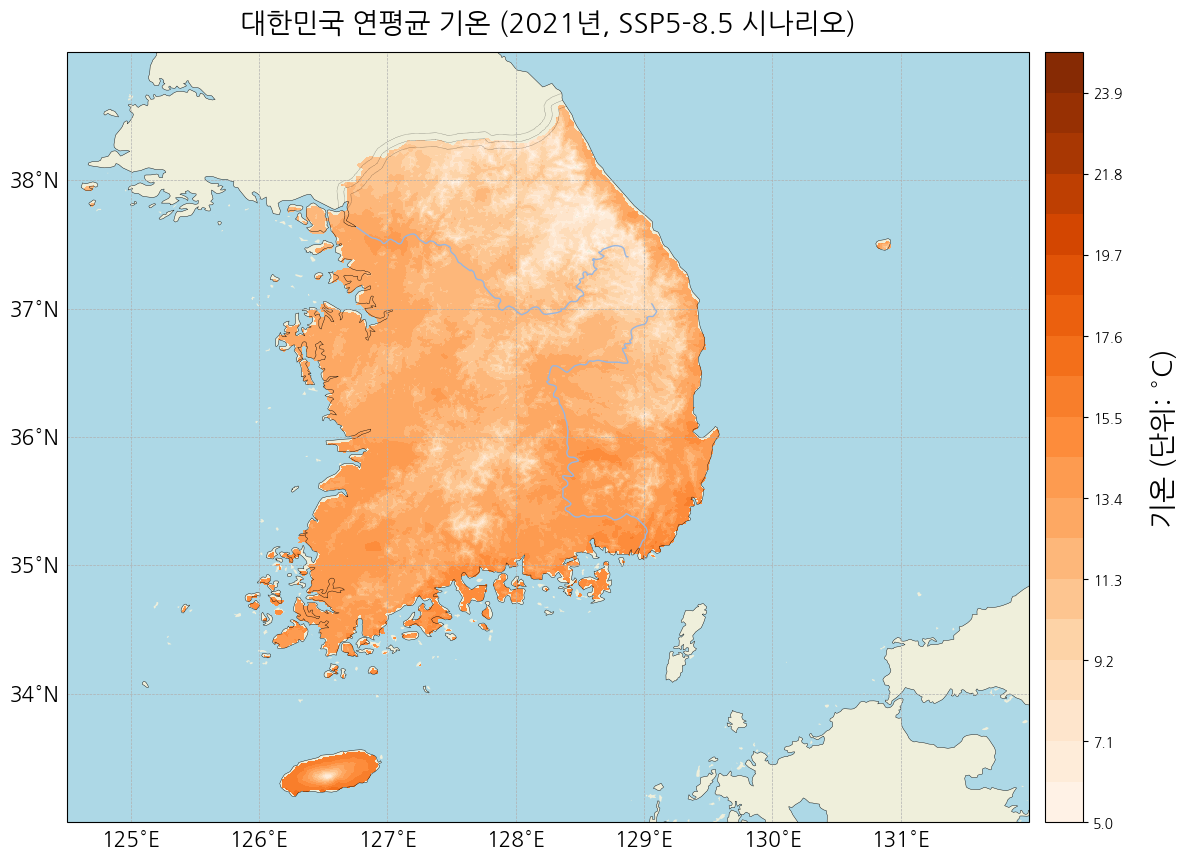

In [6]:
plt.figure(figsize=(20, 10))

ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([125, 130, 33, 39]) 
ax.add_feature(cfeature.OCEAN, color='lightblue')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, zorder=2)
gl.top_labels = False
gl.right_labels = False  
gl.xlabel_style = {'size': 15}  
gl.ylabel_style = {'size': 15}

vmin = 5
vmax = 25
levels = np.linspace(vmin, vmax, 20)

contour = plt.contourf(lon, lat, avg_temp[year_index, :, :], cmap='Oranges', vmin=vmin, vmax=vmax, levels=levels)
ax.set_title(f'대한민국 연평균 기온 ({year}년, SSP5-8.5 시나리오)', fontsize=20, pad=15)
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.01)
cbar.set_label('기온 (단위: °C)', fontsize=20, labelpad=20) 
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))

plt.show()

## 5. Create GIF image

### 5.1 Create each image (.png)

In [24]:
for year in index_time:
    plt.figure(figsize=(20, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN, color='lightblue')
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.3)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    # ax.set_extent([125, 130, 33, 39])  # 필요한 경우 주석 해제
    
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, zorder=2)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 15}  
    gl.ylabel_style = {'size': 15}
    
    ax.set_title(f'대한민국 연평균 기온 ({index_time[year]}년, SSP5-8.5 시나리오)', fontsize=20, pad=15)

    vmin = 5
    vmax = 25
    cmap = 'Oranges'
    levels = np.linspace(vmin, vmax, 20)
    
    contour = ax.contourf(lon, lat, avg_temp[year, :, :], cmap=cmap, vmin=vmin, vmax=vmax, levels=levels)
    cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.01)
    cbar.set_label('기온 (단위: °C)', fontsize=20, labelpad=20) 
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))

    png_filename = f'SSP5_8.5_Korea_{year + 2021}.png'
    png_save_path = os.path.join(SSP5_path, 'png_files', png_filename)
    plt.savefig(png_save_path, bbox_inches='tight')
    plt.close()

### 5.2 Save GIF image

In [25]:
start_date = list(index_time.values())[0]
end_date = list(index_time.values())[-1]

In [26]:
gif_filename = f'SSP5_8.5_Korea_{start_date}_{end_date}.gif'
gif_path = os.path.join(SSP5_path, 'gif_files', gif_filename)

images = []
for year in index_time:
    filename = f"{SSP5_path}/png_files/SSP5_8.5_Korea_{year + 2021}.png"
    images.append(imageio.imread(filename))

imageio.mimsave(gif_path, images, duration=2)  